In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer/sample_submission.csv
/kaggle/input/customer/Train.csv
/kaggle/input/customer/Test.csv


In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pickle

from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
train_df = pd.read_csv("/kaggle/input/customer/Train.csv")
test_df = pd.read_csv("/kaggle/input/customer/Test.csv")

In [4]:
print(train_df.shape)
train_df.head()

(8068, 11)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None
                  ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      7239.000000  7733.000000
mean   463479.214551    43.466906         2.641663     2.850123
std      2595.381232    16.711696 

In [6]:
train_df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

<Axes: xlabel='Segmentation', ylabel='count'>

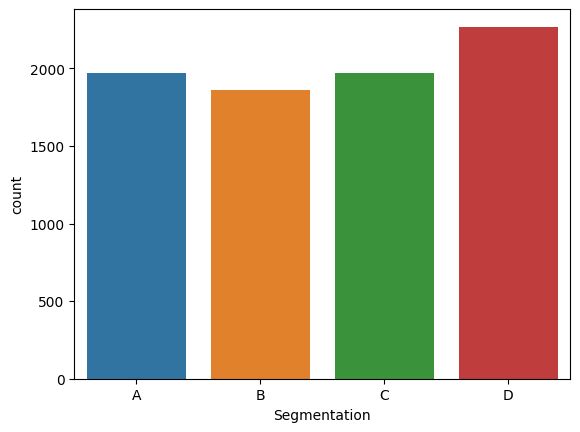

In [7]:
import seaborn as sns
sns.countplot(data=train_df, x='Segmentation', order=['A', 'B', 'C', 'D'])

## Preprocessing and Feature Engineering 

### Encoding and Handling Missing Value

In [8]:
df = train_df.copy()

In [9]:
X = df.drop(columns = ['ID', "Segmentation"])
y_raw = df["Segmentation"]

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

In [11]:
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include= ["object"]).columns

In [12]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [13]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', drop='first')
)


In [14]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])


In [15]:
X_processed = preprocessor.fit_transform(X)

In [16]:
print("Preprocessing Complete using SimpleImputer!")
print("Shape of final feature matrix (X):", X_processed.shape)
print("Shape of final target vector (y):", y.shape)



Preprocessing Complete using SimpleImputer!
Shape of final feature matrix (X): (8068, 22)
Shape of final target vector (y): (8068,)


In [17]:
X_processed

array([[-1.28462344, -0.45113599,  0.76269849, ...,  0.        ,
         0.        ,  0.        ],
       [-0.32715082, -0.45113599,  0.09580227, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.40826831, -0.45113599, -1.23799017, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.62636101, -0.45113599, -1.23799017, ...,  0.        ,
         1.        ,  0.        ],
       [-0.98541324, -0.45113599,  0.76269849, ...,  0.        ,
         1.        ,  0.        ],
       [-0.38699286, -0.7574104 ,  0.09580227, ...,  0.        ,
         0.        ,  0.        ]])

## Build and Train Model

In [18]:
inertia_errors = []
silhouette_scores = []
n_clusters = range(2,13)

for k in n_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(X_processed)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_processed,  model.labels_))


print("inertia_errors type:", type(inertia_errors))
print("inertia_errors len:", len(inertia_errors))
print("Inertia:", inertia_errors)
print()
print("silhouette_scores type:", type(silhouette_scores))
print("silhouette_scores len:", len(silhouette_scores))
print("Silhouette Scores:", silhouette_scores)

inertia_errors type: <class 'list'>
inertia_errors len: 11
Inertia: [34298.39931532892, 28338.117318805453, 25249.30383085598, 22944.59592377561, 21739.896578831875, 20866.590518995807, 20105.327073503147, 19544.450730707656, 19027.833212438716, 18678.756582551414, 18053.173544659476]

silhouette_scores type: <class 'list'>
silhouette_scores len: 11
Silhouette Scores: [0.1728344556276022, 0.2060785771756822, 0.1667742005231995, 0.18076106494060903, 0.17638467503541322, 0.16944340452113602, 0.15380397449318253, 0.1517130869441556, 0.14311171497579792, 0.12974110164882272, 0.13236674914232924]


In [19]:
fig = px.line(
    x = n_clusters,
    y = inertia_errors,
    title = "K-Means Model: Inertia vs Number of Clusters"
)

fig.update_layout(xaxis_title = "Number of Clusters", yaxis_title = "Inertia")

fig.show()

In [20]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x = n_clusters,
    y = silhouette_scores,
    title = "K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(xaxis_title = "Number of Clusters", yaxis_title = "Silhouette Score")
fig.show()

In [21]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters = 3, random_state = 42)
)

final_model.fit(X_processed)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [22]:
# X = pd.DataFrame(X_processed)

# X["cluster"] = labels

# xgb = X.groupby("cluster").mean()
# xgb


Comparison of Business Segments vs. K-Means Clusters:
KMeans_Segment   0    1    2    3    4    5    6    7    8    9    10   11
Segmentation                                                              
A                95  137   75  187  119   63  236  147   96  169  244  404
B                73  160   25  158  289   38  143  201   63  276  186  246
C               122  210   48   77  341   44   76  260   67  446  167  112
D               495   64  277  138   53  147  206   50  393   80  115  250


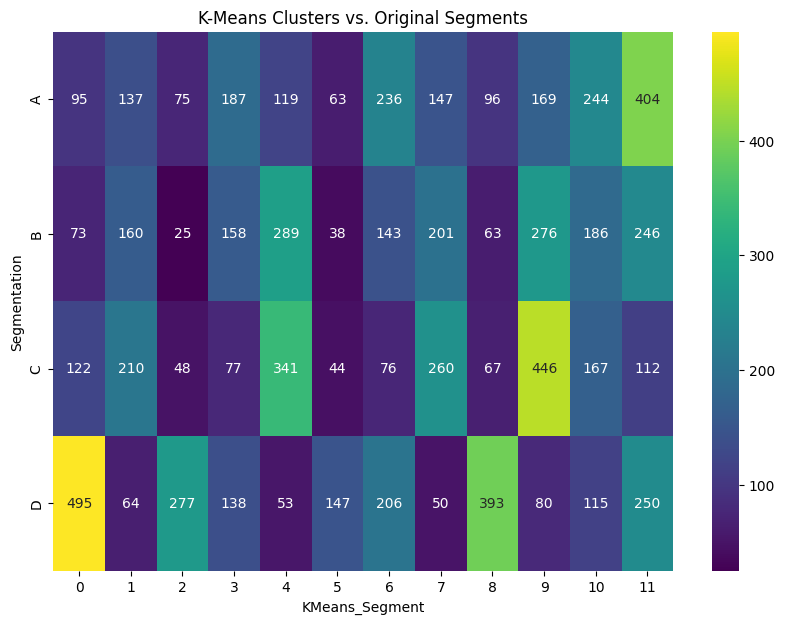

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
labels = model.fit_predict(X_processed)


train_df['KMeans_Segment'] = labels

comparison_table = pd.crosstab(train_df['Segmentation'], train_df['KMeans_Segment'])

print("Comparison of Business Segments vs. K-Means Clusters:")
print(comparison_table)

plt.figure(figsize=(10, 7))
sns.heatmap(comparison_table, annot=True, fmt='d', cmap='viridis')
plt.title('K-Means Clusters vs. Original Segments')
plt.show()

In [24]:
# # Create side-by-side bar chart of `xgb`
# fig = px.bar(
#     xgb, 
#     barmode = "group",
#     title = "Small Business Owner Finances by Cluster"
# )
# fig.update_layout(xaxis_title = "Cluster", yaxis_title = "Value [$]")
# fig.show()


In [25]:
import pandas as pd
import plotly.express as px

xgb_data = {
    'Feature_A': [1.28, 0.19, -0.70],
    'Feature_B': [-0.30, 0.00, 0.11],
    'Feature_C': [0.67, 0.56, 0.48]
}
xgb = pd.DataFrame(xgb_data)
xgb.index.name = 'cluster'
xgb_long = xgb.reset_index().melt(
    id_vars='cluster',          
    var_name='feature',         
    value_name='average_value'  
)

fig = px.bar(
    xgb_long,
    x='cluster',                
    y='average_value',          
    color='feature',            
    barmode='group',
    title="Customer Segment Profiles by Cluster"
)

fig.update_layout(xaxis_title="Cluster", yaxis_title="Average Standardized Value")
fig.show()

## PCA

In [26]:
pca = PCA(n_components = 2, random_state = 42)
X_t = pca.fit_transform(X_processed)
X_pca = pd.DataFrame(X_t, columns = ["PC1", "PC2"])
print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (8068, 2)


,PC1,PC2
0,1.736890,-0.767675
1,0.069722,-0.484468
2,-1.881008,0.333484
3,-2.002362,-0.509452
4,0.694855,-1.572405


In [27]:
fig = px.scatter(
    data_frame = X_pca,
    x = "PC1",
    y = "PC2",
    color = labels.astype(str),
    title = "PCA Representations of Clusters"
)

fig.update_layout(xaxis_title = "PC1", yaxis_title = "PC2")
fig.show()

In [28]:
feature_names = preprocessor.get_feature_names_out()

print(f"There are {len(feature_names)} final features.")
print("First 5 features:", feature_names[:5])

There are 22 final features.
First 5 features: ['num__Age' 'num__Work_Experience' 'num__Family_Size' 'cat__Gender_Male'
 'cat__Ever_Married_Yes']


In [29]:
import pandas as pd

pca_components = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=['PC1', 'PC2']
)

pc1_influential_features = pca_components.loc['PC1'].sort_values(ascending=False)

print("Most Influential Features for PC1:")
print(pc1_influential_features.head()) 
print(pc1_influential_features.tail()) 

Most Influential Features for PC1:
num__Family_Size              0.489115
num__Work_Experience          0.249911
cat__Profession_Healthcare    0.149444
cat__Spending_Score_Low       0.143220
cat__Var_1_Cat_4              0.049408
Name: PC1, dtype: float64
cat__Var_1_Cat_6         -0.108205
cat__Profession_Lawyer   -0.108934
cat__Graduated_Yes       -0.129844
cat__Ever_Married_Yes    -0.230937
num__Age                 -0.739855
Name: PC1, dtype: float64


In [30]:
# See the weights of specific features on PC2
print("\nWeights on PC2 for family-related features:")
print(pca_components.loc['PC2'][['num__Family_Size', 'cat__Ever_Married_Yes']])


Weights on PC2 for family-related features:
num__Family_Size        -0.574674
cat__Ever_Married_Yes   -0.065229
Name: PC2, dtype: float64
